# Week 9 Assignment: NLP Text classification

Create a NLP text classifier to predict whether a text message is spam. 

1) Load the dataset which includes 2 fields: (text and label) where label  indicates whether the message is “spam” or "not spam"  (eg: ham).

2) Perform basic EDA

3) Perform preprocessing of text (eg: lower-case, tokenization, removal of stop words, stemming/lemmatization, etc. as needed)

4) Vectorize Text (eg: BoW, TF-IDF, etc)

5) Create a model, using at least 2 different ML algorithms
    
 * Split the data into training and testing set
 * Train the model on training, then predict and assess performance on test
 * predict custom messages (eg: your own custom message, at least 3) to evaluate how well your model categorized it

In [1]:
import numpy as np
import pandas as pd
import string
import re
import itertools
import random
from collections import Counter
import unidecode

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk import NaiveBayesClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("spam.csv")

In [3]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Make a copy without any transformations for us with Sklearn
df_clean = df.copy()

In [5]:
# Add a length of text column before the cleaning
df['length'] = df.apply(lambda row: len(row.text), axis = 1)

## Data Cleaning & EDA

Perform the following transfermations

1. Replace the output variables of `ham` and `spam` with `1` and `0`
1. Covert all text to lowercase
1. Tokenize the words
1. Remove stop words & puncutation
1. Remove accented characters
1. Stemm the words
1. Add a column for the count of words after text is tokenized

In [6]:
# Replace the text based labels with 1 and 0
df['label'] = df.label.map({'ham': 0, 'spam': 1})
# Convert all to lowercase
df['text'] = df.text.map(lambda x: x.lower())
# Convert all to lowercase
df['text'] = df.text.map(lambda x: unidecode.unidecode(x))
# Tokenize the words
df['text'] = df['text'].apply(word_tokenize)
# Remove stopword
useless_words = stopwords.words("english") + list(string.punctuation)
useless_words = useless_words + ["...", "..", "''", "'s"]
df['text'] = df['text'].apply(lambda x: [y for y in x if not y in useless_words])
# Stem the tokenized words
stemmer = PorterStemmer() 
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])

In [7]:
# Add a length of text column
df['tok_length'] = df.apply(lambda row: len(row.text), axis = 1)

In [8]:
df.head()

,label,text,length,tok_length
0,0,"[go, jurong, point, crazi, avail, bugi, n, gre...",111,16
1,0,"[ok, lar, joke, wif, u, oni]",29,6
2,1,"[free, entri, 2, wkli, comp, win, fa, cup, fin...",155,25
3,0,"[u, dun, say, earli, hor, u, c, alreadi, say]",49,9
4,0,"[nah, n't, think, goe, usf, live, around, though]",61,8


In [9]:
df.tail()

,label,text,length,tok_length
5567,1,"[2nd, time, tri, 2, contact, u., u, aps750, po...",161,20
5568,0,"[i_, b, go, esplanad, fr, home]",37,6
5569,0,"[piti, mood, suggest]",57,3
5570,0,"[guy, bitch, act, like, 'd, interest, buy, som...",125,14
5571,0,"[rofl, true, name]",26,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   int64 
 1   text        5572 non-null   object
 2   length      5572 non-null   int64 
 3   tok_length  5572 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 174.2+ KB


In [11]:
df.describe().round(2)

,label,length,tok_length
count,5572.00,5572.00,5572.00
mean,0.13,80.12,9.59
std,0.34,59.69,7.15
min,0.00,2.00,0.00
25%,0.00,36.00,4.00
50%,0.00,61.00,7.00
75%,0.00,121.00,14.00
max,1.00,910.00,80.00


**Observations:**  
 - **Label**: This is just a binary label after changing from the categorical lables.  We'll count these in the next visualization.
 - **length**:  Character count for the text colum.  `Min` of `2` and `max` of `910`.  Mean is `80` characters meaning these are all bascially short messages not unlike Tweets.
 - **tok_length**:  Number of tokenized `words` in each message.  `Min` of `0` and `max` of `80`.  The mean number of words is approximatley `10`.

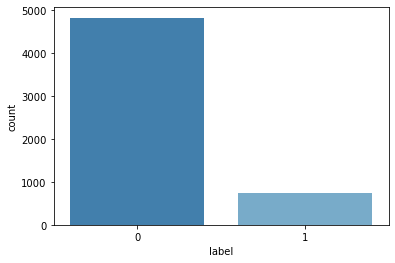

In [12]:
sns.countplot(x=df['label'], palette="tab20c");

**Count of Ham/Spam**:  There are  a far greater portion of `ham` messages in the dataset compared to `spam`.  This is known as imbalanced data.

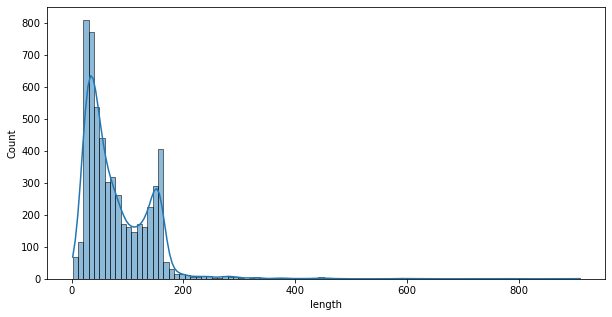

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='length', kde=True, palette="tab20c");

**Notes**:  For the lenth (char count) we can see the right skewed data with most of the observations falling under `200` characters.

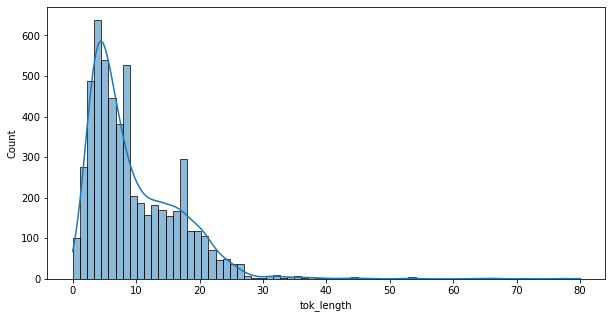

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='tok_length', kde=True, palette="tab20c");

**Notes**:  For token lenth (number of words), most fall under `30` and a large proportion have less than `10`.

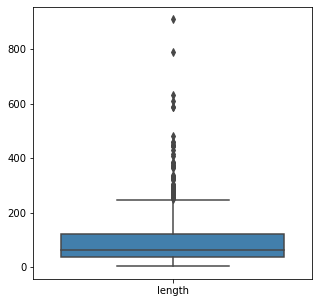

In [15]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df[['length']], palette="tab20c");

**Notes**:  Outliers can be observed outside of the upper quartile of approx `225`.

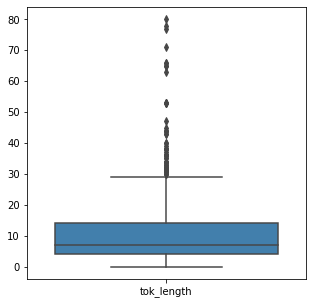

In [16]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df[['tok_length']], palette="tab20c");

**Notes**:  Outliers can be observed outside of the upper quartile of approx `225`.

In [17]:
df[df['tok_length'] > 30].text.head(n=10)

154     [everywher, dirt, floor, window, even, shirt, ...
472     [noth, meant, money, enter, account, bank, rem...
710     [height, confid, aeronaut, professor, wer, cal...
837     [sir, late, pay, rent, past, month, pay, lt, g...
881     [see, knew, give, break, time, woul, lead, alw...
1084    [love, start, attraction.i, feel, need, everi,...
1359    [lt, gt, pple, marri, lover, becz, hav, gud, u...
1384    [storm, msg, wen, u, lift, phne, u, say, \hell...
1512    [hey, sweet, wonder, moment, might, come, want...
1541    [u, konw, waht, rael, friendship, im, gving, y...
Name: text, dtype: object

**Outliers**: Given we are working with text data, there is nothing to suggest that these outliers (displayed above) are in error or will hurt our models.  They will stay in the datset.

In [18]:
# Extract only Ham
df_ham = df[df['label'] == 0]
# Extract only SPAM
df_spam = df[df['label'] == 1]

In [19]:
freq_stats_ham = []
for i in df_ham['text']:
    freq_stats_ham = freq_stats_ham + i

In [20]:
fdist_ham = FreqDist(freq_stats_ham)
fdist_ham.most_common(20)

[('u', 980),
 ('go', 417),
 ("'m", 387),
 ('get', 357),
 ("n't", 346),
 ('gt', 318),
 ('lt', 316),
 ('2', 300),
 ('come', 295),
 ('call', 291),
 ('know', 248),
 ('like', 244),
 ('got', 242),
 ('love', 241),
 ('ok', 240),
 ('ur', 237),
 ('good', 230),
 ('time', 228),
 ("'ll", 228),
 ('want', 212)]

**Frequent Spam Words:**  
The top most frequently occuring words are `call`, `free`, `2`, `txt`, `u`, `ur`, `text`, and `mobile`.  A lot of these seem to be about free serives, gifts, prizes.  Certainly something that seems `spam` related. 

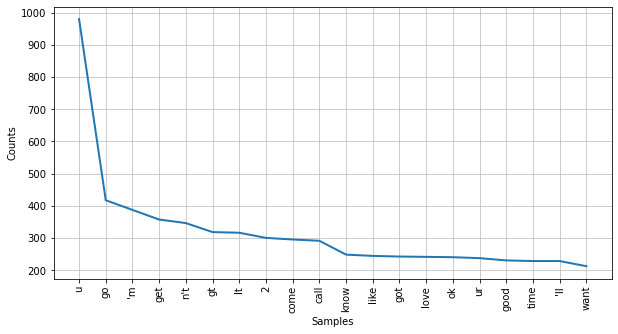

In [21]:
plt.figure(figsize=(10, 5))
fdist_ham.plot(20, cumulative=False)
plt.show()

In [22]:
freq_stats_spam = []
for i in df_spam['text']:
    freq_stats_spam = freq_stats_spam + i

In [23]:
fdist_spam = FreqDist(freq_stats_spam)
fdist_spam.most_common(20)

[('call', 365),
 ('free', 219),
 ('2', 174),
 ('txt', 169),
 ('ur', 144),
 ('u', 141),
 ('text', 139),
 ('mobil', 135),
 ('4', 120),
 ('claim', 115),
 ('stop', 114),
 ('repli', 112),
 ('prize', 94),
 ('get', 88),
 ('tone', 74),
 ('servic', 72),
 ('send', 70),
 ('new', 69),
 ('nokia', 68),
 ('award', 66)]

**Frequent Spam Words:**  
The top most frequently occuring words are `call`, `free`, `2`, `txt`, `u`, `ur`, `text`, and `mobile`.  A lot of these seem to be about free serives, gifts, prizes.  Certainly something that seems `spam` related. 

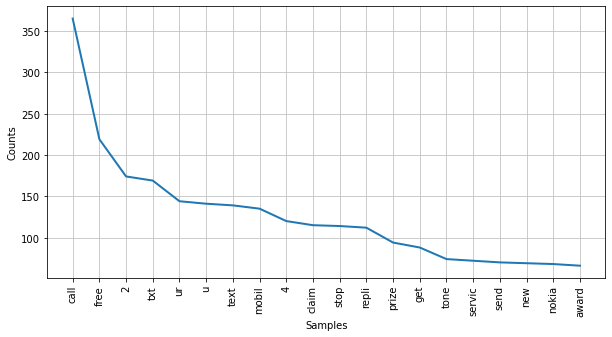

In [24]:
plt.figure(figsize=(10, 5))
fdist_spam.plot(20, cumulative=False)
plt.show()

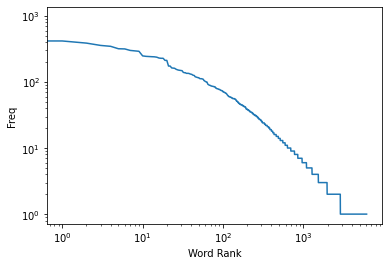

In [25]:
word_counter_ham = Counter(freq_stats_ham)
sorted_word_counts_ham = sorted(list(word_counter_ham.values()), reverse=True) 

plt.loglog(sorted_word_counts_ham)
plt.ylabel('Freq')
plt.xlabel('Word Rank');

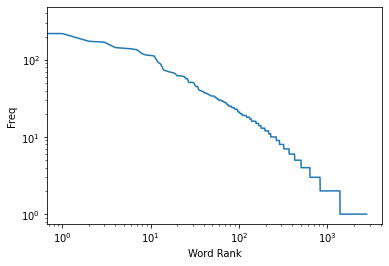

In [26]:
word_counter_spam = Counter(freq_stats_spam)
sorted_word_counts_spam = sorted(list(word_counter_spam.values()), reverse=True) 

plt.loglog(sorted_word_counts_spam)
plt.ylabel('Freq')
plt.xlabel('Word Rank');

In [27]:
# Change the order of the columns and remove anything we don't need post analysis.
df = df[['text', 'label']].copy()

# NLTK Classifier

We will use the NLTK `NaiveBayesClassifier` to build a classification model for our spam and ham.  The process for building the Bag of Words is simple with NLTK, building a tuple in the following format

`({ "word": count, "word2": count}, class)`

The following function creates this for each observation in the datset.

In [28]:
X = df['text']
y = df.label

In [29]:
X.shape

(5572,)

In [30]:
y.shape

(5572,)

In [31]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

In [32]:
X_train.shape

(4457,)

In [33]:
X_test.shape

(1115,)

In [34]:
y_train.value_counts()

0    3834
1     623
Name: label, dtype: int64

In [35]:
y_test.value_counts()

0    991
1    124
Name: label, dtype: int64

**Note**:  
Before the data is oversampled, there are `623` spam entries in the training set and `124` in the test set.

## Oversample the Minority Class
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.  
We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html?highlight=resample

In [36]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [37]:
# separate minority and majority classes
ham = X[X.label == 0]
spam = X[X.label == 1]

In [38]:
# upsample minority
spam_upsampled = resample(spam,
                          replace=True, # sample with replacement
                          n_samples=len(ham), # match number in majority class
                          random_state=27) # reproducible results

In [39]:
# combine majority and upsampled minority
upsampled = pd.concat([ham, spam_upsampled])

In [40]:
# check new class counts
upsampled.label.value_counts()

0    3834
1    3834
Name: label, dtype: int64

**Note**:    
Now that the data is oversampled, there is an equal number of `0` and `1` observations.

### Build BoW for `Train` Data and Validate

In [41]:
# Extract only Ham
train_ham = upsampled[upsampled['label'] == 0]
# Extract only SPAM
train_spam = upsampled[upsampled['label'] == 1]

In [42]:
# build a bad of words Function
def build_bag_of_words_features(words):
    return {word:1 for word in words}

In [43]:
# builds a list of positive reviews words/features with stop words and punction removed
ham_train_features = [(build_bag_of_words_features(x), 'ham') for x in train_ham['text']]

print(ham_train_features[0])

({'place': 1, 'get': 1, 'room': 1, 'cheap': 1}, 'ham')


In [44]:
# builds a list of positive reviews words/features with stop words and punction removed
spam_train_features = [(build_bag_of_words_features(x), 'spam') for x in train_spam['text']]

print(spam_train_features[0])

({'valu': 1, 'custom': 1, 'pleas': 1, 'advis': 1, 'follow': 1, 'recent': 1, 'review': 1, 'mob': 1, 'award': 1, 'aps1500': 1, 'bonu': 1, 'prize': 1, 'call': 1, '09066364589': 1}, 'spam')


In [45]:
train = ham_train_features + spam_train_features
random.shuffle(train)

sent_classifier = NaiveBayesClassifier.train(train)

In [46]:
print('num features for train: ', len(train))

nltk.classify.util.accuracy(sent_classifier, train)*100

num features for train:  7668


97.70474700052165

### Build BoW for `Test` Data and Validate

In [47]:
# concatenate our training data back together
all_test = pd.concat([X_test, y_test], axis=1)

In [48]:
# Extract only Ham
test_ham = all_test[all_test['label'] == 0]
# Extract only SPAM
test_spam = all_test[all_test['label'] == 1]

In [49]:
# builds a list of positive reviews words/features with stop words and punction removed
ham_test_features = [(build_bag_of_words_features(x), 'ham') for x in test_ham['text']]

print(ham_test_features[0])

({'aiyah': 1, 'ok': 1, 'wat': 1, 'long': 1, 'got': 1, 'improv': 1, 'alreadi': 1}, 'ham')


In [50]:
# builds a list of positive reviews words/features with stop words and punction removed
spam_test_features = [(build_bag_of_words_features(x), 'spam') for x in test_spam['text']]

print(spam_test_features[0])

({'2nd': 1, 'time': 1, 'tri': 1, '2': 1, 'contact': 1, 'u.': 1, 'u': 1, '750': 1, 'pound': 1, 'prize': 1, 'claim': 1, 'easi': 1, 'call': 1, '08718726970': 1, '10p': 1, 'per': 1, 'min': 1, 'bt-national-r': 1}, 'spam')


In [51]:
test = ham_test_features + spam_test_features

print('num features for test: ', len(test))

nltk.classify.util.accuracy(sent_classifier, test)*100

num features for test:  1115


94.52914798206278

In [52]:
sent_classifier.show_most_informative_features(n=100)

Most Informative Features
                   award = 1                spam : ham    =    221.0 : 1.0
                 voucher = 1                spam : ham    =    129.0 : 1.0
                 landlin = 1                spam : ham    =    117.7 : 1.0
                   nokia = 1                spam : ham    =    110.2 : 1.0
                   await = 1                spam : ham    =     98.3 : 1.0
                    code = 1                spam : ham    =     95.7 : 1.0
                     txt = 1                spam : ham    =     91.5 : 1.0
                      16 = 1                spam : ham    =     87.0 : 1.0
                      uk = 1                spam : ham    =     83.7 : 1.0
                  latest = 1                spam : ham    =     78.2 : 1.0
                     100 = 1                spam : ham    =     75.7 : 1.0
                  urgent = 1                spam : ham    =     74.3 : 1.0
                    draw = 1                spam : ham    =     67.0 : 1.0

**Observations**:  When displaying `100` of the top informative features, **most** of these are `spam:ham` ratios, meaning that the weight of the effect of these words ends up predicting a `spam` message.  In the most weighted case, the word `award` is `221` times more probable of being a spam message.  The word `home` is the highest weighted ham word with a `23:1` mulitiple of being not spam.

### Test with Custom Data

In [53]:
# get the training vocabulary
train_vocab = set()

for t in train:
    vocabDict = t[0]
    for key in vocabDict.keys():
      train_vocab.add(key)
len(train_vocab)

7108

In [57]:
from nltk.tokenize import word_tokenize

docs=["txt us at 8787 for a free trip to hawaii!", 
      "I'm looking forward to when my day is over and I can go home",
      "Nah I don't think he goes to usf",
      "Your award for a free week of mobile service"]

for doc in docs:
     t_features = {word: (word in word_tokenize(doc.lower())) for word in train_vocab}
     print(doc," : ", sent_classifier.classify(t_features)) 

txt us at 8787 for a free trip to hawaii!  :  spam
I'm looking forward to when my day is over and I can go home  :  ham
Nah I don't think he goes to usf  :  ham
Your award for a free week of mobile service  :  spam


### Findings

With the NLTK model, the accuracy on the `test` partition of the data was about `~94%`.  When testing our sample strings it ended up classifying them correctly.  It's very possible to make just minor word changes and have these mis-classify, however this does show the model working properly.

# Scikit Learn Naive Bayes Classification

The following section will look to classify the data based on Scikit-Learn's `NaiveBayesClassification`, and specifically the `MultinomialNB` algorithm.  A number of options through different versions of the same process

1. **Four total passes**
    - The first two will use an imbalanced dataset
    - The second two will use a balanced training set
1. **For each of the two passes, different word vectorization will be used.**
    - `CountVectorizer` which uses a sparse matrix of token counts per document
    - `TfidfVectorizer` Tf-idf instead of the token counts, scales down the impact of tokens that occur very frequently in a given corpus and that are hence less informative than features that occur in a small fraction of the training corpus.
1. **Hyper Parameter Tuning**
    - Each of the passes will use a Grid Search Cross Validation to pick the best performing `alpha` setting.  This is tuned per training data set, and per word vectorization model from step 2.

After everything is run, we can see which model performed the best.  The metric for determining the best model is `percision` primarily, since it will measure how precise/accurate the model is out of those predicted positive, how many of them are actual positive.

>Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model[3].

**Note:** Different than the NLTK version above, we will not do any special pre-processing but rather let `scikit-learn` do stop word removal and accent removal.  Because of this, we'll start with the raw imported CSV.

**References:**  
 1. [Detecting Fake News with Scikit-Learn](https://www.datacamp.com/community/tutorials/scikit-learn-fake-news)  
 1. [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
 1. [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

In [58]:
df = df_clean.copy()

# Set `y` 
y = df.label
X = df['text']

# Drop the `label` column
df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [59]:
print(y_train.shape)
print(X_train.shape)

(3733,)
(3733,)


## Models on Original Dataset

In [60]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [61]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [62]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['yuo', 'yuou', 'yup', 'yupz', 'zebra', 'zed', 'zeros', 'zhong', 'zoe', 'zogtorius']
['00', '000', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400']


In [63]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df

,00,000,008704050406,0089,01223585236,01223585334,0125698789,02,0207,02072069400,...,yuo,yuou,yup,yupz,zebra,zed,zeros,zhong,zoe,zogtorius
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3731,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [64]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,00,000,008704050406,0089,01223585236,01223585334,0125698789,02,0207,02072069400,...,yuo,yuou,yup,yupz,zebra,zed,zeros,zhong,zoe,zogtorius
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.266889,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

**Note:** The empty `set` denotes that the features (columns) are identical between the models.

### Function for Plotting Confusion Matrix

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

### Function for Hyper Parameter Tuning

GridSearch Cross Validation of `alpha` parameter.

In [67]:
def get_alpha(X, y):
    vals = np.linspace(.0001, 2, 100)

    parameters = {'alpha':vals}
    model = MultinomialNB()
    clf = GridSearchCV(model, parameters)
    clf.fit(X, y)

    # extract the best alpha score
    return clf.best_params_

In [68]:
alph_dict = get_alpha(count_train, y_train)
alph = alph_dict['alpha']
alph

1.4949747474747475

In [69]:
clf = MultinomialNB(alpha=alph) 

              precision    recall  f1-score   support

         ham      0.989     0.996     0.993      1602
        spam      0.973     0.928     0.950       237

    accuracy                          0.987      1839
   macro avg      0.981     0.962     0.972      1839
weighted avg      0.987     0.987     0.987      1839

accuracy:   0.987
Confusion matrix, without normalization


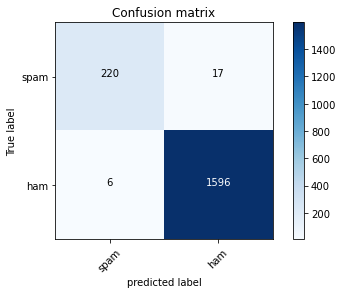

In [70]:
clf.fit(count_train, y_train)
y_pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [71]:
alph_dict = get_alpha(tfidf_train, y_train)
alph = alph_dict['alpha']
alph

0.3031151515151515

In [72]:
clf = MultinomialNB(alpha=alph) 

              precision    recall  f1-score   support

         ham      0.981     0.999     0.990      1602
        spam      0.995     0.869     0.928       237

    accuracy                          0.983      1839
   macro avg      0.988     0.934     0.959      1839
weighted avg      0.983     0.983     0.982      1839

accuracy:   0.983
Confusion matrix, without normalization


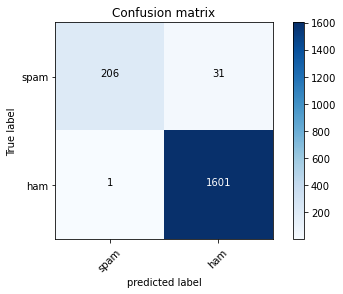

In [73]:
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

## Oversample the Minority Class
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.  
We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html?highlight=resample

In [74]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [75]:
# separate minority and majority classes
ham = X[X.label == 'ham']
spam = X[X.label == 'spam']

In [76]:
# upsample minority
spam_upsampled = resample(spam,
                          replace=True, # sample with replacement
                          n_samples=len(ham), # match number in majority class
                          random_state=27) # reproducible results

In [77]:
# combine majority and upsampled minority
upsampled = pd.concat([ham, spam_upsampled])

In [78]:
# check new class counts
upsampled.label.value_counts()

ham     3223
spam    3223
Name: label, dtype: int64

**Note:** Now we can see that the number of `spam` and `ham` entries are the same

## Post Oversampling Models

In [79]:
# balanced dataset
y_train = upsampled.label
X_train = upsampled.text

In [80]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [81]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [82]:
alph_dict = get_alpha(count_train, y_train)
alph = alph_dict['alpha']
alph

0.0001

**Note**: The very low `alpha` value returned suggest that our model might be overfit to the data.

In [83]:
clf = MultinomialNB(alpha=alph) 

              precision    recall  f1-score   support

         ham      0.986     0.981     0.984      1602
        spam      0.878     0.907     0.892       237

    accuracy                          0.972      1839
   macro avg      0.932     0.944     0.938      1839
weighted avg      0.972     0.972     0.972      1839

accuracy:   0.972
Confusion matrix, without normalization


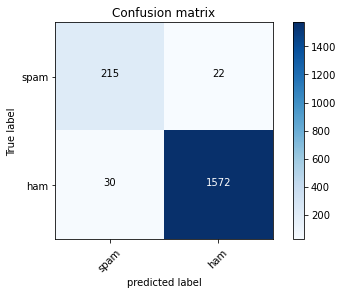

In [84]:
clf.fit(count_train, y_train)
y_pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [85]:
alph_dict = get_alpha(tfidf_train, y_train)
alph = alph_dict['alpha']
alph

0.0001

**Note**: The very low `alpha` value returned suggest that our model might be overfit to the data.

In [86]:
clf = MultinomialNB(alpha=alph) 

              precision    recall  f1-score   support

         ham      0.984     0.980     0.982      1602
        spam      0.868     0.890     0.879       237

    accuracy                          0.968      1839
   macro avg      0.926     0.935     0.931      1839
weighted avg      0.969     0.968     0.969      1839

accuracy:   0.968
Confusion matrix, without normalization


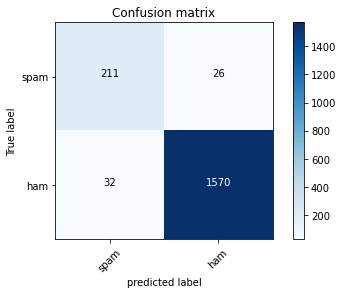

In [87]:
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

## Test with Custom Data

In [88]:
samples = ["txt us at 8787 for a free trip to hawaii!", 
      "I'm looking forward to when my day is over and I can go home",
      "Nah I don't think he goes to usf",
      "Your award for a free week of mobile service"]

In [89]:
for sample in samples:
    sample_trans = tfidf_vectorizer.transform([sample])
    print(sample, "=", clf.predict(sample_trans))

txt us at 8787 for a free trip to hawaii! = ['spam']
I'm looking forward to when my day is over and I can go home = ['ham']
Nah I don't think he goes to usf = ['ham']
Your award for a free week of mobile service = ['spam']


## Findings


https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

# Clustering with Kmeans

It's possible to apply the same methods of vecorization, specifically `TF-IDF` and use an unsupervised model such as `kMeans` to build a number of clusters representing different groupings of like data.  Since we know there are naturally `2` clusters in here, we can try to run the algorithm with the `spam` and `ham` label removed.  

After the model is built, we can try our sample strings against the clusters seeing if they are placed logically in the right ones.

In [90]:
df = df_clean.copy()

X = df['text']

# Drop the `label` column
df.drop("label", axis=1, inplace=True)

In [91]:
# vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

In [92]:
# train k-means model
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1, random_state=999)
model.fit(X)


print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind]),
    print('\n')
    
    

Top terms per cluster:
Cluster 0:
 ok
 ll
 come
 gt
 lt
 just
 good
 know
 got
 sorry
 like
 later
 time
 home
 lor


Cluster 1:
 ur
 free
 text
 txt
 mobile
 reply
 claim
 stop
 prize
 cash
 www
 won
 send
 nokia
 contact




In [93]:
print("Predictions:")
samples = ["txt us at 8787 for a free trip to hawaii!", 
      "I'm looking forward to when my day is over and I can go home",
      "Nah I don't think he goes to usf",
      "Your award for a free week of mobile service"]

# prediction
pred = model.predict(vectorizer.transform(samples))
print(pred)

Predictions:
[1 0 0 1]


**kMeans Notes:**  

The kMeans clustering unsupervised algorithm with two clusters comes up with an approimation of a `spam` and a `ham` cluster.  feeding in the same items from our prior tests result in the same predictions.  `#1` and `#4` predicted as `spam`, and `#2` and `#3` as `ham`.

While you wouldn't use an unsupervised method when you have actual labels, it demonstrates really well how clustering, an unsupervised method, can be used on text.  It is also very useful when you have some subject matter on the text, where we know there are generally `2` labels we're looking for.